# Drive Mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/PINN

/content/drive/.shortcut-targets-by-id/1kBpsdlzoY9Dl5Og9N1a-GxSNoIkIrQV4/PINN


In [4]:
!ls -l

total 1165
drwx------ 2 root root   4096 Feb  6 06:29  ar_377_2011-02-12T00:00:00
drwx------ 2 root root   4096 Feb  6 01:28  AR_377_series
drwx------ 2 root root   4096 Feb  6 08:03  ar_7115_2017-09-06T08:36:00
drwx------ 2 root root   4096 Feb  6 07:56  AR_7115_series
drwx------ 2 root root   4096 Feb  7 10:24  ar_series_377_2011-02-12T00:00:00
drwx------ 2 root root   4096 Feb  6 08:03  ar_series_7115_2017-09-06T08:36:00
-rw------- 1 root root  85086 Feb  5 13:45  energy.png
-rw------- 1 root root    324 Feb  7 05:09 'explorer data provided by authors.ipynb'
-rw------- 1 root root 741117 Feb  7 11:10 'extrapolation AR377.ipynb'
-rw------- 1 root root 126578 Feb  7 23:11 'extrapolation AR7115.ipynb'
-rw------- 1 root root  72789 Feb  7 05:11  hmi_cropped_binning.png
-rw------- 1 root root  75924 Feb  7 05:11  hmi_cropped.png
-rw------- 1 root root  63855 Feb  7 05:11  hmi_original.png


In [5]:
duration = '4h'

## Import

In [28]:
!pip install -q git+https://github.com/RobertJaro/NF2.git

  Preparing metadata (setup.py) ... done


In [29]:
# general imports
import glob
import os
from datetime import datetime
from dateutil.parser import parse
import shutil

# download
import drms
from urllib import request

# data processing
import numpy as np
from astropy.nddata import block_reduce
from sunpy.map import Map

# deep learning
import torch

# NF2
from nf2.train.trainer import NF2Trainer
from nf2.data.download import download_HARP, find_HARP, donwload_ds
from nf2.train.metric import *
from nf2.evaluation.unpack import load_cube
from nf2.evaluation.energy import get_free_mag_energy
from nf2.data.loader import load_hmi_data
from nf2.train.metric import energy

# visualization
from matplotlib import pyplot as plt

In [30]:
jsoc_email = 'mgjeon@khu.ac.kr'
client = drms.Client(email=jsoc_email, verbose=True)

noaa_nums = [12673]
year = 2017
month = 9
day = 6
hour = 8
minute = 36

date = datetime(year, month, day, hour, minute)

sharp_nr = find_HARP(date, noaa_nums, client)
print(sharp_nr)

7115


In [31]:
bin = 2
spatial_norm = 160 
height = 160 
b_norm = 2500  
d_slice = None

dim = 256

lambda_div = 0.1 
lambda_ff = 0.1 
iterations = 10e4 
iterations = int(iterations)
decay_iterations = 5e4 
decay_iterations = int(decay_iterations)
batch_size = 1e4 
batch_size = int(batch_size)
log_interval = 1e4 
log_interval = int(log_interval)
validation_interval = 1e4 
validation_interval = int(validation_interval)
potential = True

In [48]:
base_path = './ar_%d_%s' % (sharp_nr, date.isoformat('T'))
series_base_path = './ar_series_%d_%s' % (sharp_nr, date.isoformat('T'))
series_download_dir = './AR_7115_series'
bpp = os.path.join(series_base_path, 'base')

In [49]:
os.makedirs(base_path, exist_ok=True)
os.makedirs(series_base_path, exist_ok=True)
os.makedirs(bpp, exist_ok=True)
os.makedirs(series_download_dir, exist_ok=True)

# Download HMI FITS

In [ ]:
ds = 'hmi.sharp_cea_720s[%d][%s/%s]{Br, Bp, Bt, Br_err, Bp_err, Bt_err}' % \
     (sharp_nr, date.isoformat('_', timespec='seconds'), duration)
donwload_ds(ds, series_download_dir, client)

Export request pending. [id=JSOC_20230206_211, status=2]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20230206_211, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20230206_211, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20230206_211, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20230206_211, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20230206_211, status=1]
Waiting for 5 seconds...
    record: hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI]
  filename: hmi.sharp_cea_720s.7115.20170906_083600_TAI.Bp.fits
  -> AR_7115_series/hmi.sharp_cea_720s.7115.20170906_083600_TAI.Bp.fits
    record: hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI]
  filename: hmi.sharp_cea_720s.7115.20170906_083600_TAI.Bt.fits
  -> AR_7115_series/hmi.sharp_cea_720s.7115.20170906_083600_TAI.Bt.fits
    record: hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI]
  filename: hmi.sharp_cea_720s.7115.20170906_08360

,record,url,download
0,hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI],http://jsoc.stanford.edu/SUM39/D1606926797/S00...,/content/drive/.shortcut-targets-by-id/1kBpsdl...
1,hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI],http://jsoc.stanford.edu/SUM39/D1606926797/S00...,/content/drive/.shortcut-targets-by-id/1kBpsdl...
2,hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI],http://jsoc.stanford.edu/SUM39/D1606926797/S00...,/content/drive/.shortcut-targets-by-id/1kBpsdl...
3,hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI],http://jsoc.stanford.edu/SUM39/D1606926797/S00...,/content/drive/.shortcut-targets-by-id/1kBpsdl...
4,hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI],http://jsoc.stanford.edu/SUM39/D1606926797/S00...,/content/drive/.shortcut-targets-by-id/1kBpsdl...
...,...,...,...
115,hmi.sharp_cea_720s[7115][2017.09.06_12:24:00_TAI],http://jsoc.stanford.edu/SUM39/D1606926797/S00...,/content/drive/.shortcut-targets-by-id/1kBpsdl...
116,hmi.sharp_cea_720s[7115][2017.09.06_12:24:00_TAI],http://jsoc.stanford.edu/SUM39/D1606926797/S00...,/content/drive/.shortcut-targets-by-id/1kBpsdl...
117,hmi.sharp_cea_720s[7115][2017.09.06_12:24:00_TAI],http://jsoc.stanford.edu/SUM39/D1606926797/S00...,/content/drive/.shortcut-targets-by-id/1kBpsdl...
118,hmi.sharp_cea_720s[7115][2017.09.06_12:24:00_TAI],http://jsoc.stanford.edu/SUM39/D1606926797/S00...,/content/drive/.shortcut-targets-by-id/1kBpsdl...


# Example 7115

In [34]:
target = os.path.join(base_path, 'extrapolation_result.nf2')

In [ ]:
request.urlretrieve('http://kanzelhohe.uni-graz.at/nf2/example_7115.nf2', 'example_7115.nf2')
shutil.move('example_7115.nf2', target)

'./ar_7115_2017-09-06T08:36:00/extrapolation_result.nf2'

In [35]:
state = torch.load(target)
state

{'model': BModel(
   (d_in): Linear(in_features=3, out_features=256, bias=True)
   (linear_layers): ModuleList(
     (0): Linear(in_features=256, out_features=256, bias=True)
     (1): Linear(in_features=256, out_features=256, bias=True)
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): Linear(in_features=256, out_features=256, bias=True)
     (4): Linear(in_features=256, out_features=256, bias=True)
     (5): Linear(in_features=256, out_features=256, bias=True)
     (6): Linear(in_features=256, out_features=256, bias=True)
     (7): Linear(in_features=256, out_features=256, bias=True)
   )
   (d_out): Linear(in_features=256, out_features=3, bias=True)
   (activation): Sine()
 ),
 'cube_shape': [344, 224, 160],
 'b_norm': 2500,
 'spatial_norm': 160,
 'meta_info': MetaDict([('simple', True),
           ('bitpix', 32),
           ('naxis', 2),
           ('naxis1', 688),
           ('naxis2', 448),
           ('pcount', 0),
           ('gcount', 1),
           ('xt

In [ ]:
state['meta_info']['rsun_obs']

951.890380859375

# Series Training

In [36]:
new_meta_path = target

In [37]:
series_iterations = 2000
series_batch_size = int(1e4)
series_log_interval = 2000
series_validation_interval = -1

In [51]:
# scan all data files
hmi_p_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bp.fits')))  # x
hmi_t_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bt.fits')))  # y
hmi_r_files = sorted(glob.glob(os.path.join(series_download_dir, '*Br.fits')))  # z
err_p_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bp_err.fits')))  # x
err_t_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bt_err.fits')))  # y
err_r_files = sorted(glob.glob(os.path.join(series_download_dir, '*Br_err.fits')))  # z

for hmi_p, hmi_t, hmi_r, err_p, err_t, err_r in zip(hmi_p_files, hmi_t_files, hmi_r_files,
                                                    err_p_files, err_t_files, err_r_files):
    file_id = os.path.basename(hmi_p).split('.')[3]
    bp = os.path.join(bpp, file_id)

    # check if finished
    final_model_path = os.path.join(bp, 'final.pt')
    print(final_model_path)
    #print(os.path.exists(final_model_path))
    if os.path.exists(final_model_path):
        new_meta_path = final_model_path
        continue
    
    # data pre-processing; same as for the single extrapolation
    hmi_cube, error_cube, meta_info = load_hmi_data([hmi_p, err_p, hmi_r, err_r, hmi_t, err_t])
    
    if d_slice is not None:
      hmi_cube = hmi_cube[d_slice[0]:d_slice[1], d_slice[2]:d_slice[3]]
      error_cube = error_cube[d_slice[0]:d_slice[1], d_slice[2]:d_slice[3]]
    if bin > 1:
      hmi_cube = block_reduce(hmi_cube, (bin, bin, 1), np.mean)
      error_cube = block_reduce(error_cube, (bin, bin, 1), np.mean)
    print(hmi_cube.shape)
    trainer = NF2Trainer(bp, hmi_cube, error_cube, height, spatial_norm, b_norm, 
                         meta_info=meta_info, dim=dim, 
                         lambda_div=lambda_div, lambda_ff=lambda_ff,
                         meta_path=new_meta_path, use_potential_boundary=potential)
    trainer.train(series_iterations, series_batch_size, 
                  series_log_interval, series_validation_interval)
    new_meta_path = final_model_path

./ar_series_7115_2017-09-06T08:36:00/base/20170906_083600_TAI/final.pt
./ar_series_7115_2017-09-06T08:36:00/base/20170906_084800_TAI/final.pt
./ar_series_7115_2017-09-06T08:36:00/base/20170906_090000_TAI/final.pt
./ar_series_7115_2017-09-06T08:36:00/base/20170906_091200_TAI/final.pt
./ar_series_7115_2017-09-06T08:36:00/base/20170906_092400_TAI/final.pt
./ar_series_7115_2017-09-06T08:36:00/base/20170906_093600_TAI/final.pt
./ar_series_7115_2017-09-06T08:36:00/base/20170906_094800_TAI/final.pt
./ar_series_7115_2017-09-06T08:36:00/base/20170906_100000_TAI/final.pt
./ar_series_7115_2017-09-06T08:36:00/base/20170906_101200_TAI/final.pt
./ar_series_7115_2017-09-06T08:36:00/base/20170906_102400_TAI/final.pt
./ar_series_7115_2017-09-06T08:36:00/base/20170906_103600_TAI/final.pt
./ar_series_7115_2017-09-06T08:36:00/base/20170906_104800_TAI/final.pt
./ar_series_7115_2017-09-06T08:36:00/base/20170906_110000_TAI/final.pt
./ar_series_7115_2017-09-06T08:36:00/base/20170906_111200_TAI/final.pt
./ar_s

# Evaluation

In [60]:
nf2_paths = sorted(glob.glob(os.path.join(bpp, '**', 'extrapolation_result.nf2')))

# save results as npy files
eval_magnetic_field_path = os.path.join(series_base_path, 'eval_magnetic_field')
os.makedirs(eval_magnetic_field_path, exist_ok=True)
magnetic_field_files = []
for path in nf2_paths:
  f = os.path.join(eval_magnetic_field_path, '%s.npy' % path.split('/')[-2])
  if os.path.exists(f): 
    magnetic_field_files += [f]
    continue
  b = load_cube(path, progress=True)
  np.save(f, b)
  magnetic_field_files += [f]

series_dates = [datetime.strptime(os.path.basename(f), '%Y%m%d_%H%M%S_TAI.npy') for f in magnetic_field_files]

In [70]:
eval_energy_path = os.path.join(series_base_path, 'eval_energy')
os.makedirs(eval_energy_path, exist_ok=True)
energy_files = []

for path in magnetic_field_files:
  f = os.path.join(eval_energy_path, os.path.basename(path))
  if os.path.exists(f): 
    energy_files += [f]
    continue
  b = np.load(path)
  me = energy(b)
  np.save(f, me)
  energy_files += [f]

energy_series_dates = [datetime.strptime(os.path.basename(f), '%Y%m%d_%H%M%S_TAI.npy') for f in energy_files]

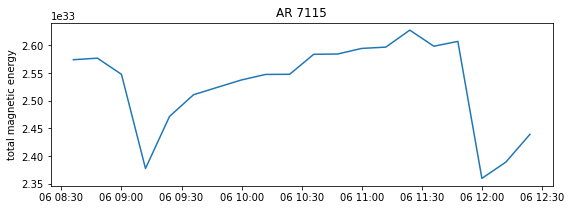

In [75]:
cm_per_pixel = 360e5 * bin
dV = cm_per_pixel**3

plt.figure(figsize=(9, 3))
plt.plot(energy_series_dates, [np.load(f).sum()*dV for f in energy_files])
plt.title('AR 7115')
plt.ylabel('total magnetic energy')
figure_energy_path = os.path.join(series_base_path, './energy.png')
plt.savefig(figure_energy_path, dpi=300)
plt.show()

In [73]:
eval_free_energy_path = os.path.join(series_base_path, 'eval_free_energy')
os.makedirs(eval_free_energy_path, exist_ok=True)
free_energy_files = []

for path in magnetic_field_files:
  f = os.path.join(eval_free_energy_path, os.path.basename(path))
  if os.path.exists(f): 
    free_energy_files += [f]
    continue
  b = np.load(path)
  free_me = get_free_mag_energy(b)
  np.save(f, free_me)
  free_energy_files += [f]

free_energy_series_dates = [datetime.strptime(os.path.basename(f), '%Y%m%d_%H%M%S_TAI.npy') for f in free_energy_files]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Potential Field: 100%|██████████| 12329/12329 [07:19<00:00, 28.05it/s]


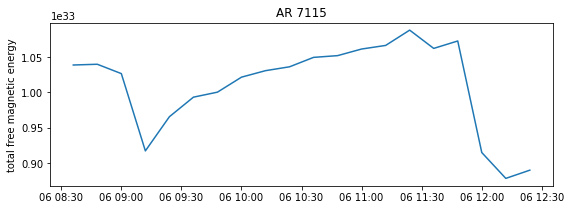

In [76]:
cm_per_pixel = 360e5 * bin
dV = cm_per_pixel**3

plt.figure(figsize=(9, 3))
plt.plot(free_energy_series_dates, [np.load(f).sum()*dV for f in free_energy_files])
plt.title('AR 7115')
plt.ylabel('total free magnetic energy')
figure_free_energy_path = os.path.join(series_base_path, './free_energy.png')
plt.savefig(figure_free_energy_path, dpi=300)
plt.show()